# XID+ was not rerun on sources within 1.5'' of HELP sources with SPIRE fluxes

I reran 1000 of these sources using their optical position from LOFAR catalogues to see how the properties differ

In [2]:
from astropy.io import ascii, fits
import astropy
import pylab as plt
%matplotlib inline
from astropy import wcs
from astropy.table import Table,Column,join,hstack,vstack
from astropy.coordinates import SkyCoord
from astropy import units as u
import pymoc
import glob
from time import sleep
import os


import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
import xidplus.catalogue as cat

import sys
from herschelhelp_internal.utils import inMoc,flux_to_mag
from xidplus.stan_fit import SPIRE

import aplpy
import seaborn as sns
#sns.set(color_codes=True)
import pandas as pd
#sns.set_style("white")
import xidplus.posterior_maps as postmaps
from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
import pyvo as vo
import glob

import copy

In [38]:
help_masterlist = Table.read('../../../../../HELP/dmu_products/dmu32/dmu32_ELAIS-N1/data/ELAIS-N1_20171020.fits')

In [14]:
lofar_orig = Table.read('data/data_release/final_cross_match_catalogue-v0.1.fits')

In [15]:
file_list = glob.glob('data/fir/*/*.fits')
file_array = np.array(file_list)

In [16]:
lofar_fir_table = Table.read(file_list[0])
for i,filename in enumerate(file_list[1:]):
    
    if i%50==0:
        print(i)
    new_table = Table.read(filename,memmap=False)
    print(len(new_table))
    lofar_fir_table = vstack([lofar_fir_table,new_table])

In [19]:
lofar_fir_table = Table.read(file_list[0])
lofar_fir_table.rename_column('HELP_ID','Source_Name')

In [20]:
lofar_fir_table[:5]

Source_Name,RA,Dec,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500
,degrees,degrees,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,
bytes27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
ILTJ155957.58+550052.4,239.98983453474398,55.01474018731156,2.633387,6.228094,0.663738,1.3079756,3.1338458,0.3111937,1.048908,2.7467842,0.28547323,-0.34661895,-2.0815296,-5.683776,0.8815817,1.4022075,2.5859828,0.9988378,1.0004802,1.0008198,1762.1398,2691.5273,2509.331,0.714,0.989,0.995
ILTJ155958.25+550105.3,239.99305177118114,55.018064321921955,2.16305,5.196661,0.5563506,1.1586523,2.4875307,0.30308855,1.3440087,3.2629051,0.35027194,-0.34661895,-2.0815296,-5.683776,0.8815817,1.4022075,2.5859828,0.99936223,0.9984354,1.003511,2015.2133,2362.608,1989.1544,0.719,0.993,0.99
ILTJ155959.52+545751.0,239.99794615446612,54.964420570378955,1.4099845,2.9844573,0.38928246,0.80649203,1.7167598,0.22033727,0.8578626,2.2045612,0.2199702,-0.34661895,-2.0815296,-5.683776,0.8815817,1.4022075,2.5859828,1.003289,0.99944466,0.9991206,1872.5781,2113.1084,2250.6208,0.869,0.999,0.964
ILTJ160001.30+550713.3,240.00563627246643,55.120416383783606,4.1993985,8.476581,1.3005711,6.224815,13.176337,1.9774741,4.062767,9.357815,1.0137466,-0.34661895,-2.0815296,-5.683776,0.8815817,1.4022075,2.5859828,1.0003303,0.99998695,0.9996246,2086.3967,2860.4985,2064.2375,0.986,0.383,0.999
ILTJ160002.20+550250.3,240.00918229308155,55.047333570881975,0.51918614,1.2103933,0.1396991,0.75791657,1.7541158,0.21236734,2.0433307,4.646838,0.50984126,-0.34661895,-2.0815296,-5.683776,0.8815817,1.4022075,2.5859828,0.99925405,0.9987088,0.9994087,2591.1365,2173.6997,3265.231,0.036,0.879,0.513


In [23]:
lofar_xid_join = join(lofar_orig,lofar_fir_table,join_type='inner',keys='Source_Name')

In [25]:
lofar_xid_join[:5]

Source_Name,RA_1,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,FLAG_WORKFLOW,Prefilter,lr_fin,optRA,optDec,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,NUMBER,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,NUMBER_OPTICAL,NUMBER_SPITZER,FLAG_OVERLAP,Separation,help_id,RA_HELP,DEC_HELP,EBV,Z_SPEC,CLASS_STAR,u_flux,u_fluxerr,g_flux,g_fluxerr,r_flux,r_fluxerr,i_flux,i_fluxerr,z_flux,z_fluxerr,y_flux,y_fluxerr,g_hsc_flux,g_hsc_fluxerr,r_hsc_flux,r_hsc_fluxerr,i_hsc_flux,i_hsc_fluxerr,z_hsc_flux,z_hsc_fluxerr,y_hsc_flux,y_hsc_fluxerr,nb921_hsc_flux,nb921_hsc_fluxerr,J_flux,J_fluxerr,K_flux,K_fluxerr,ch1_servs_flux,ch1_servs_fluxerr,ch2_servs_flux,ch2_servs_fluxerr,ch1_swire_flux,ch1_swire_fluxerr,ch2_swire_flux,ch2_swire_fluxerr,ch3_swire_flux,ch3_swire_fluxerr,ch4_swire_flux,ch4_swire_fluxerr,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250_1,FErr_SPIRE_250_u_1,FErr_SPIRE_250_l_1,F_SPIRE_350_1,FErr_SPIRE_350_u_1,FErr_SPIRE_350_l_1,F_SPIRE_500_1,FErr_SPIRE_500_u_1,FErr_SPIRE_500_l_1,Bkg_SPIRE_250_1,Bkg_SPIRE_350_1,Bkg_SPIRE_500_1,Sig_conf_SPIRE_250_1,Sig_conf_SPIRE_350_1,Sig_conf_SPIRE_500_1,Rhat_SPIRE_250_1,Rhat_SPIRE_350_1,Rhat_SPIRE_500_1,n_eff_SPIRE_250_1,n_eff_SPIRE_500_1,n_eff_SPIRE_350_1,Pval_res_250_1,Pval_res_350_1,Pval_res_500_1,flag_spire_250,flag_spire_350,flag_spire_500,AGN,optAGN,IRAGN,XrayAGN,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,hp_idx_11,hp_depth_cluster,RA_2,Dec,F_SPIRE_250_2,FErr_SPIRE_250_u_2,FErr_SPIRE_250_l_2,F_SPIRE_350_2,FErr_SPIRE_350_u_2,FErr_SPIRE_350_l_2,F_SPIRE_500_2,FErr_SPIRE_500_u_2,FErr_SPIRE_500_l_2,Bkg_SPIRE_250_2,Bkg_SPIRE_350_2,Bkg_SPIRE_500_2,Sig_conf_SPIRE_250_2,Sig_conf_SPIRE_350_2,Sig_conf_SPIRE_500_2,Rhat_SPIRE_250_2,Rhat_SPIRE_350_2,Rhat_SPIRE_500_2,n_eff_SPIRE_250_2,n_eff_SPIRE_500_2,n_eff_SPIRE_350_2,Pval_res_250_2,Pval_res_350_2,Pval_res_500_2
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,degrees,degrees,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,
bytes27,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,bytes22,bytes17,bytes22,int64,int64,int64,float32,float32,float64,float64,int64,int64,int32,int64,float64,bytes27,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float32,float32,bool,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bool,bool,bool,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,i

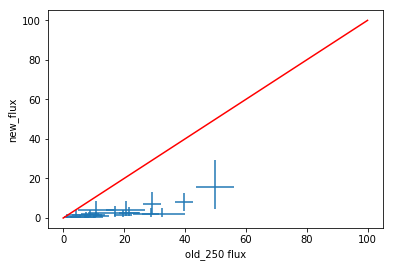

In [34]:
x = lofar_xid_join['F_SPIRE_250_1']
y = lofar_xid_join['F_SPIRE_250_2']
xerru = lofar_xid_join['FErr_SPIRE_250_u_1'] - lofar_xid_join['F_SPIRE_250_1']
xerrl = lofar_xid_join['F_SPIRE_250_1'] - lofar_xid_join['FErr_SPIRE_250_l_1']
yerru = lofar_xid_join['FErr_SPIRE_250_u_2'] - lofar_xid_join['F_SPIRE_250_2']
yerrl = lofar_xid_join['F_SPIRE_250_2'] - lofar_xid_join['FErr_SPIRE_250_l_2']

plt.errorbar(x,y,yerr=[yerrl,yerru],xerr=[xerrl,xerru],linestyle='')
plt.plot([0,100],[0,100],c='red')
plt.xlabel('old_250 flux')
plt.ylabel('new_flux')
plt.show()

In [66]:
priors,posterior = xidplus.load('data/fir/xidplus_run_0/lofar_xidplus_fir_0_rerun.pkl.pkl')

In [67]:
import xidplus.catalogue as cat
SPIRE_cat=cat.create_SPIRE_cat(posterior,priors[0],priors[1],priors[2])
SPIRE_cat = Table.read(SPIRE_cat)
SPIRE_cat.rename_column('HELP_ID','help_id')

In [68]:
print(len(SPIRE_cat))
SPIRE_cat[:5]

86


help_id,RA,Dec,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500
,degrees,degrees,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,
str27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
HELP_J155950.647+550050.336,239.96103054900786,55.01398214247973,3.7959318,8.221087,1.143642,10.932362,17.45879,4.478888,9.532871,17.16827,3.4719024,-3.8795059,-6.9436827,-12.025908,0.5616385,1.9361963,3.5851505,1.0016282,1.0035772,0.99975085,1706.868,3409.7524,2160.8374,0.0,0.006,0.04
HELP_J155951.163+550043.799,239.963177504057,55.0121664954993,13.116873,16.470121,9.203321,8.032034,14.398264,2.5646212,6.8762283,14.202708,2.129282,-3.8795059,-6.9436827,-12.025908,0.5616385,1.9361963,3.5851505,0.9997874,1.0013567,0.9995053,2108.3638,2514.1497,2166.448,0.0,0.0,0.029
HELP_J155951.572+550107.988,239.96488487214904,55.01888567710409,3.1289887,5.88078,1.0707941,2.059159,4.5460887,0.5750845,4.3814664,8.626925,1.3601532,-3.8795059,-6.9436827,-12.025908,0.5616385,1.9361963,3.5851505,0.99945205,0.99922377,0.9986871,2425.712,2608.5637,3485.6885,0.0,0.0,0.015
HELP_J155953.408+545756.709,239.972532082057,54.9657524234993,17.57056,20.658777,14.417516,12.053624,15.662454,8.342798,3.295113,7.4574933,0.92279816,-3.8795059,-6.9436827,-12.025908,0.5616385,1.9361963,3.5851505,0.9986526,0.99985266,0.99929136,3807.5046,3412.9028,2820.307,0.0,0.008,0.023
HELP_J155953.486+550057.711,239.97285627705702,55.0160308604993,9.9849415,13.818113,6.05959,2.4677503,5.1952667,0.7301498,1.8184015,4.5423684,0.43647322,-3.8795059,-6.9436827,-12.025908,0.5616385,1.9361963,3.5851505,0.9996969,1.0003734,0.99912757,2386.4126,3051.0837,3107.7056,0.0,0.0,0.004


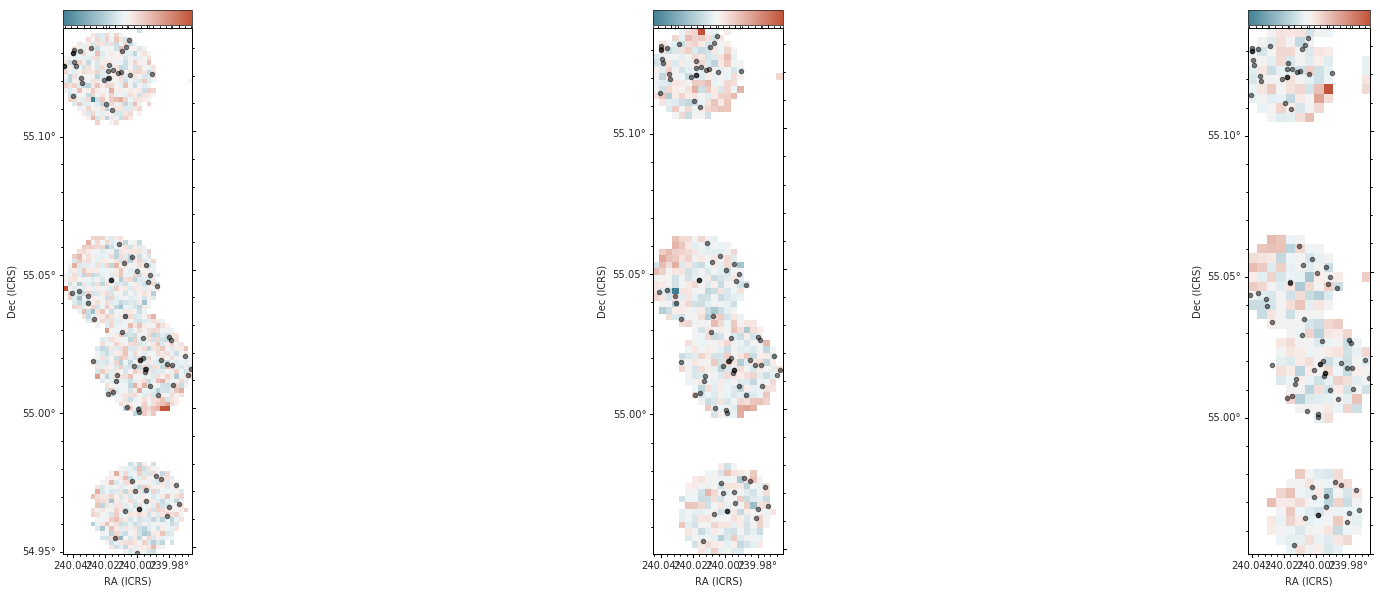

In [78]:
figs, fig=xidplus.plot_Bayes_pval_map(priors, posterior)

In [69]:
help_join_xid = join(help_masterlist,SPIRE_cat,join_type='inner',keys='help_id')

In [70]:
help_join_xid[:5]

help_id,field,ra,dec,hp_idx,ebv,redshift,zspec,f_wfc_u,ferr_wfc_u,f_ap_wfc_u,ferr_ap_wfc_u,m_wfc_u,merr_wfc_u,m_ap_wfc_u,merr_ap_wfc_u,flag_wfc_u,f_megacam_u,ferr_megacam_u,f_ap_megacam_u,ferr_ap_megacam_u,m_megacam_u,merr_megacam_u,m_ap_megacam_u,merr_ap_megacam_u,flag_megacam_u,f_suprime_g,ferr_suprime_g,f_ap_suprime_g,ferr_ap_suprime_g,m_suprime_g,merr_suprime_g,m_ap_suprime_g,merr_ap_suprime_g,flag_suprime_g,f_megacam_g,ferr_megacam_g,f_ap_megacam_g,ferr_ap_megacam_g,m_megacam_g,merr_megacam_g,m_ap_megacam_g,merr_ap_megacam_g,flag_megacam_g,f_gpc1_g,ferr_gpc1_g,f_ap_gpc1_g,ferr_ap_gpc1_g,m_gpc1_g,merr_gpc1_g,m_ap_gpc1_g,merr_ap_gpc1_g,flag_gpc1_g,f_wfc_g,ferr_wfc_g,f_ap_wfc_g,ferr_ap_wfc_g,m_wfc_g,merr_wfc_g,m_ap_wfc_g,merr_ap_wfc_g,flag_wfc_g,f_suprime_r,ferr_suprime_r,f_ap_suprime_r,ferr_ap_suprime_r,m_suprime_r,merr_suprime_r,m_ap_suprime_r,merr_ap_suprime_r,flag_suprime_r,f_gpc1_r,ferr_gpc1_r,f_ap_gpc1_r,ferr_ap_gpc1_r,m_gpc1_r,merr_gpc1_r,m_ap_gpc1_r,merr_ap_gpc1_r,flag_gpc1_r,f_wfc_r,ferr_wfc_r,f_ap_wfc_r,ferr_ap_wfc_r,m_wfc_r,merr_wfc_r,m_ap_wfc_r,merr_ap_wfc_r,flag_wfc_r,f_megacam_r,ferr_megacam_r,f_ap_megacam_r,ferr_ap_megacam_r,m_megacam_r,merr_megacam_r,m_ap_megacam_r,merr_ap_megacam_r,flag_megacam_r,f_gpc1_i,ferr_gpc1_i,f_ap_gpc1_i,ferr_ap_gpc1_i,m_gpc1_i,merr_gpc1_i,m_ap_gpc1_i,merr_ap_gpc1_i,flag_gpc1_i,f_suprime_i,ferr_suprime_i,f_ap_suprime_i,ferr_ap_suprime_i,m_suprime_i,merr_suprime_i,m_ap_suprime_i,merr_ap_suprime_i,flag_suprime_i,f_wfc_i,ferr_wfc_i,f_ap_wfc_i,ferr_ap_wfc_i,m_wfc_i,merr_wfc_i,m_ap_wfc_i,merr_ap_wfc_i,flag_wfc_i,f_gpc1_z,ferr_gpc1_z,f_ap_gpc1_z,ferr_ap_gpc1_z,m_gpc1_z,merr_gpc1_z,m_ap_gpc1_z,merr_ap_gpc1_z,flag_gpc1_z,f_wfc_z,ferr_wfc_z,f_ap_wfc_z,ferr_ap_wfc_z,m_wfc_z,merr_wfc_z,m_ap_wfc_z,merr_ap_wfc_z,flag_wfc_z,f_megacam_z,ferr_megacam_z,f_ap_megacam_z,ferr_ap_megacam_z,m_megacam_z,merr_megacam_z,m_ap_megacam_z,merr_ap_megacam_z,flag_megacam_z,f_suprime_z,ferr_suprime_z,f_ap_suprime_z,ferr_ap_suprime_z,m_suprime_z,merr_suprime_z,m_ap_suprime_z,merr_ap_suprime_z,flag_suprime_z,f_suprime_n921,ferr_suprime_n921,f_ap_suprime_n921,ferr_ap_suprime_n921,m_suprime_n921,merr_suprime_n921,m_ap_suprime_n921,merr_ap_suprime_n921,flag_suprime_n921,f_gpc1_y,ferr_gpc1_y,f_ap_gpc1_y,ferr_ap_gpc1_y,m_gpc1_y,merr_gpc1_y,m_ap_gpc1_y,merr_ap_gpc1_y,flag_gpc1_y,f_suprime_y,ferr_suprime_y,f_ap_suprime_y,ferr_ap_suprime_y,m_suprime_y,merr_suprime_y,m_ap_suprime_y,merr_ap_suprime_y,flag_suprime_y,f_ukidss_j,ferr_ukidss_j,f_ap_ukidss_j,ferr_ap_ukidss_j,m_ukidss_j,merr_ukidss_j,m_ap_ukidss_j,merr_ap_ukidss_j,flag_ukidss_j,f_ukidss_k,ferr_ukidss_k,f_ap_ukidss_k,ferr_ap_ukidss_k,m_ukidss_k,merr_ukidss_k,m_ap_ukidss_k,merr_ap_ukidss_k,flag_ukidss_k,f_irac_i1,ferr_irac_i1,f_ap_irac_i1,ferr_ap_irac_i1,m_irac_i1,merr_irac_i1,m_ap_irac_i1,merr_ap_irac_i1,flag_irac_i1,f_irac_i2,ferr_irac_i2,f_ap_irac_i2,ferr_ap_irac_i2,m_irac_i2,merr_irac_i2,m_ap_irac_i2,merr_ap_irac_i2,flag_irac_i2,f_irac_i3,ferr_irac_i3,f_ap_irac_i3,ferr_ap_irac_i3,m_irac_i3,merr_irac_i3,m_ap_irac_i3,merr_ap_irac_i3,flag_irac_i3,f_irac_i4,ferr_irac_i4,f_ap_irac_i4,ferr_ap_irac_i4,m_irac_i4,merr_irac_i4,m_ap_irac_i4,merr_ap_irac_i4,flag_irac_i4,f_mips_24,ferr_mips_24,flag_mips_24,f_pacs_green,ferr_pacs_green,flag_pacs_green,f_pacs_red,ferr_pacs_red,flag_pacs_red,f_spire_250,ferr_spire_250,flag_spire_250,f_spire_350,ferr_spire_350,flag_spire_350,f_spire_500,ferr_spire_500,flag_spire_500,cigale_mstar,cigale_mstar_err,cigale_sfr,cigale_sfr_err,cigale_dustlumin,cigale_dustlumin_err,cigale_dustlumin_ironly,cigale_dustlumin_ironly_err,flag_cigale,flag_cigale_opt,flag_cigale_ir,flag_cigale_ironly,stellarity,stellarity_origin,flag_cleaned,flag_merged,flag_gaia,flag_optnir_obs,flag_optnir_det,zspec_qual,zspec_association_flag,RA,Dec,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPI

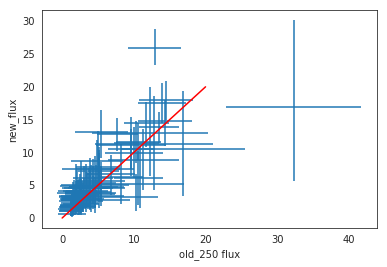

In [72]:
x = help_join_xid['f_spire_250']/1000
y = help_join_xid['F_SPIRE_250']
xerr = help_join_xid['ferr_spire_250']/1000
yerru = help_join_xid['FErr_SPIRE_250_u'] - help_join_xid['F_SPIRE_250']
yerrl = help_join_xid['F_SPIRE_250'] - help_join_xid['FErr_SPIRE_250_l']

plt.errorbar(x,y,yerr=[yerrl,yerru],xerr=xerr,linestyle='')
plt.plot([0,20],[0,20],c='red')
plt.xlabel('old_250 flux')
plt.ylabel('new_flux')
plt.show()

8


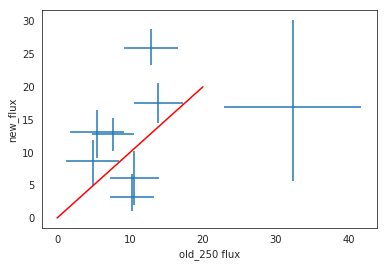

ValueError: operands could not be broadcast together with shapes (77,) (8,) 

In [77]:
diff = abs(x-y)
mask = diff>xerr
print(np.sum(mask))
x = help_join_xid['f_spire_250'][mask]/1000
y = help_join_xid['F_SPIRE_250'][mask]
xerr = help_join_xid['ferr_spire_250'][mask]/1000
yerru = help_join_xid['FErr_SPIRE_250_u'][mask] - help_join_xid['F_SPIRE_250'][mask]
yerrl = help_join_xid['F_SPIRE_250'][mask] - help_join_xid['FErr_SPIRE_250_l'][mask]

plt.errorbar(x,y,yerr=[yerrl,yerru],xerr=xerr,linestyle='')
plt.plot([0,20],[0,20],c='red')
plt.xlabel('old_250 flux')
plt.ylabel('new_flux')
plt.show()

mask_new = diff>(yerru+yerrl)/2
print(np.sum(mask_new))

In [75]:
len(diff)

77